# INFO 602 Final Project - InfoSec Open Source Intelligence (OSINT) Categorization
Michael Poff

## Executive Summary

### Purpose and Objective
The project aimed to develop an automated model to categorize information security news articles efficiently. This endeavor was propelled by the necessity to stay abreast of the latest cybersecurity threats, vulnerabilities, and industry updates within a limited daily research window. The primary goal was to streamline the process of identifying relevant news, thereby saving time and enhancing the capability to respond promptly to emerging cybersecurity threats.

### Methodology
The project commenced with an exploration of zero-shot classification models, specifically evaluating the bart-large-mnli model for its potential to categorize articles without requiring labeled training data. Despite its innovative approach, zero-shot classification yielded limited success, with an average accuracy rate of 44% and significant prediction confidence issues, as indicated by a Cross-Entropy Loss ranging from 2.42 to 13.55.

Subsequently, the focus shifted towards traditional NLP techniques, implementing a Bag of Words model with TF-IDF weighting. This transition marked a significant improvement in model performance, especially with the integration of the MLPClassifier, achieving a precision of 73%, recall of 71%, and a weighted average F1-score of 72%. The model's Cross-Entropy Loss was notably reduced to 0.774, underscoring enhanced prediction confidence.

Further advancements were realized through the incorporation of sentence and document embeddings, utilizing SBERT and OpenAI's embeddings. This approach provided more nuanced text representations, capturing semantic relationships more effectively. The MLPClassifier, combined with OpenAI Embeddings, emerged as the most effective model, showcasing a precision of 76%, recall of 75%, and a weighted average F1-score of 74%, along with the lowest observed Cross-Entropy Loss of 0.7255. These metrics highlighted the model's superior performance in accurately categorizing cybersecurity content.

### Conclusion
The iterative refinement and adoption of advanced NLP techniques culminated in the development of a highly effective categorization model, significantly outperforming initial expectations and methodologies. The final model, an MLPClassifier with OpenAI Embeddings, demonstrated exceptional accuracy and efficiency, providing a robust solution to the challenge of sifting through vast quantities of cybersecurity news. This project not only achieved its objective of streamlining the information review process for cybersecurity professionals but also set a new standard in the application of machine learning and AI for cybersecurity information management.

### Future Opportunities
Ongoing efforts will concentrate on refining the model, incorporating additional contextual information, and expanding the dataset to encompass a wider array of cybersecurity topics. Ensuring the model's adaptability and accuracy in the dynamically evolving cybersecurity landscape remains a priority, with continuous evaluation and adaptation being key to sustaining its effectiveness and relevance.

## Setup

In [16]:
import os
import warnings
import torch
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import string
from IPython.display import display, Markdown
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import *
from imblearn.pipeline import Pipeline
from sklearn.neural_network import *
from sklearn.naive_bayes import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
import numpy as np
import plotly_express as px
from sklearn.linear_model import *
import tiktoken
from openai import OpenAI
from transformers import pipeline
from dotenv import load_dotenv
import json

load_dotenv()

warnings.filterwarnings('ignore')

os.environ["TOKENIZERS_PARALLELISM"] = "true"

# Set the device for performing analysis with certain transformers
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
    
    OPENAI_API_KEY = ""  # DELETE BEFORE COMMIT!!!

# Establish an OpenAI client for working with the OpenAI API
OPENAI_API_KEY = os.getenv("OAI_KEY")

client = OpenAI(
    api_key=OPENAI_API_KEY
)

## Data

In [17]:
data = pd.read_excel('./data/article_data.xlsx')[['content', 'category']]
display(Markdown(
    f"The dataset contains {len(data)} data points, each of which represents an article scraped from a number of information security news and intelligence providers (listed below). Each row contains the following features:"))

The dataset contains 345 data points, each of which represents an article scraped from a number of information security news and intelligence providers (listed below). Each row contains the following features:

### Data Dictionary   

- Title: The title of the article.
-   Content: The article contents.
-   Category: A manually labeled category label, chosen from one of nine options (listed below).
-   Zero-Shot Category: A label applied by the [HuggingFace zero-shot classification transformer](https://huggingface.co/tasks/zero-shot-classification) using the same set of nine options.
-   Zero-Shot Match: Indicates whether the zero-shot classification corresponds with the manual category assignment, expressed as TRUE or FALSE.

### Categories

**1. Vulnerability Reports**
Articles that detail specific software or hardware vulnerabilities, often including technical descriptions, severity assessments, and potential impact.

Classification Guidance:
-  Mentions of CVE identifiers (Common Vulnerabilities and Exposures).
-  Technical analysis or proof-of-concept code.
-  Discussions on vulnerability scores (e.g., CVSS scores).
-  Mention of affected platforms, software, or hardware.

**2. Security Updates and Patches**
These articles focus on the release of security updates, patches, or workarounds intended to fix vulnerabilities or improve security.

Classification Guidance:
-  Announcements from software or hardware vendors.
-  Instructions or recommendations for patching or updating systems.
-  Discussions of specific issues fixed by the update or patch.
-  References to advisory publications from vendors or security organizations.

**3. Emerging Threats and Attack Techniques**
Articles covering new or evolving cybersecurity threats, including novel attack vectors, malware, ransomware, or phishing campaigns.

Classification Guidance:
-  Descriptions of novel or evolving attack methodologies or exploit techniques.
-  Analysis of threat actors or campaigns.
-  Statistics or reports on the rise of specific threats.
-  Case studies or examples of recent attacks.
-  Focus on novel or evolving threat.
-  Novel research into system vulnerabilities without technical details or classifications (CVE).

**4. Regulatory Changes and Compliance**
Coverage of changes in cybersecurity laws, regulations, or standards, and how organizations can achieve compliance.

Classification Guidance:
-  Mention of specific legal acts, regulations, or compliance frameworks (e.g., GDPR, CCPA, HIPAA, SOC 2).
-  Guidance or advice on compliance strategies.
-  Analysis of the impact of regulatory changes on businesses or industries.
-  Expert commentary or interviews with legal or compliance professionals.

**5. Data Breaches and Security Incidents**
Reports on specific incidents where data has been exposed, stolen, or otherwise compromised, including details on the nature of the breach, affected parties, and aftermath. May be a breach or incident involving a wide-ranging scope (single company, to thousands of devices). Not every mention of an incident automatically classifies in this category, the distinction depends on the article's focus, depth of coverage regarding the specific incident, and the context in which the incident is mentioned.

Classification Guidance:
-  Specific details of the incident (what, when, how).
-  Information on the data compromised (types of data, number of records).
-  Responses or statements from the affected organization.
-  Analysis of the breach’s impact or lessons learned.
-  Specific details of an incident.

**6. News and Industry Updates**
General news related to the infosec industry, including market trends, mergers and acquisitions, or significant appointments and departures.

Classification Guidance:
-  Coverage of significant events or changes within infosec companies or organizations.
-  Market analysis or trends in cybersecurity.
-  Announcements of significant new technologies or products.
-  Profiles or interviews with industry leaders.
-  Specific government actions against individuals or groups.

**7. Marketing**
Articles or content primarily aimed at promoting specific cybersecurity products, services, or brands.

Classification Guidance:
-  Direct mentions of product features or benefits.
-  Comparisons with competing products or services.
-  Testimonials, case studies, or customer stories.
-  Content that focuses more on persuasion rather than providing objective information or analysis.

### Sources
-   [The Hacker News](https://thehackernews.com/)
-   [Bleeping Computer](https://www.bleepingcomputer.com/)
-   [Dark Reading](https://www.darkreading.com/)
-   [CISA Advisories](https://www.cisa.gov/news-events/cybersecurity-advisories)
-   [The Register - Security](https://www.theregister.com/security/)
-  [Cybersecurity Dive](https://www.cybersecuritydive.com/)

### Notes
The article data were scraped using the Python library [Trafilatura](https://github.com/adbar/trafilatura) which does a good job of scraping content and metadata from article web pages, however some results are skewed. Rather than manually refine the data, the model should learn to ignore this extraneous text.

## Preprocessing

This section tokenizes the contents of each article into words and sentences. Preprocessing on the data includes normalizing all content to lowercase, replacing common abbreviations that may be confused for stop words, removing URLs, removing punctuation, removing stop words, removing non-ascii characters, and [lemmatizing](https://en.wikipedia.org/wiki/Lemmatization) the words, and removing single character tokens. Finally, all words are joined into a single string and added as another feature in the dataset. 

Thanks to Afham Fardeen for his [guide](https://machinelearningknowledge.ai/11-techniques-of-text-preprocessing-using-nltk-in-python/) to performing text preprocessing.

In [18]:
# Load the spaCy English model
nlp = spacy.load('en_core_web_lg')

# Add custom stop words
# Removing security, cybersecurity, and data to see if that improves model performance (worth noting after the fact that this didn't improve accuracy, but improved recall across the board by about 20%.
custom_stopwords = {'said', 'say', 'use', 'include', 'security', 'cybersecurity', 'data', 'datum'}
for word in custom_stopwords:
    nlp.Defaults.stop_words.add(word)

# Convert the data in the content column to lowercase
data['content'] = data['content'].str.lower()


# Perform sentence tokenization
def sentence_tokenize(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences


data['sentences'] = data['content'].apply(sentence_tokenize)


# Handle abbreviations in the data that align with stopwords
def replace_abbreviations(text):
    replacements = {'u.s.': 'usa', 'u.s': 'usa'}
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text


data['content'] = data['content'].apply(replace_abbreviations)


# Remove urls from the data
def remove_urls(text):
    # Regex pattern for matching URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Replace URLs with an empty string
    return re.sub(url_pattern, '', text)


# Apply the URL removal function before processing the text with spaCy
data['content'] = data['content'].apply(remove_urls)


def remove_punctuation_from_text(text):
    # Create a translation table where each punctuation mark is mapped to a space
    table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    # Use the translation table to replace punctuation with spaces in the text
    return text.translate(table)


data['content'] = data['content'].apply(remove_punctuation_from_text)


# Function to process text with spaCy, incorporating tokenization, stop word removal, lemmatization, and non-ASCII removal
def process_text(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_ascii and not token.is_punct:
            if token.lemma_.lower() == "datum":  # some instances of the word data were being lematized to datum and others were not, normalizing on the word data rather than datum.
                token.lemma_ = "data"

            tokens.append(token.lemma_.lower())
    return tokens


data['words'] = data['content'].apply(process_text)


# Remove tokens that are a single character long
def remove_short_tokens(text):
    result = []
    for word in text:
        if len(word) > 1:
            result.append(word)
    return result


data['words'] = data['words'].apply(remove_short_tokens)

data['processed_content'] = data['words'].apply(lambda x: ' '.join(x))

words = pd.DataFrame(data[['words', 'category']])
del data['words']

## Exploratory Data Analysis

### Data Preview
First, a quick look at a row of data. This is limited to a single row because the contents are quite large.

In [19]:
data.head(1).style.set_properties(**{'background-color': 'black',
                                     'color': 'white',
                                     'border-color': 'gray'})

,content,category,sentences,processed_content
0,the usa cybersecurity and infrastructure security agency cisa on wednesday added a high severity flaw impacting ios ipados macos tvos and watchos to its known exploited vulnerabilities kev catalog based on evidence of active exploitation the vulnerability tracked as cve 2022 48618 cvss score 7 8 concerns a bug in the kernel component an attacker with arbitrary read and write capability may be able to bypass pointer authentication apple said in an advisory adding the issue may have been exploited against versions of ios released before ios 15 7 1 the iphone maker said the problem was addressed with improved checks it s currently not known how the vulnerability is being weaponized in real world attacks interestingly patches for the flaw were released on december 13 2022 with the release of ios 16 2 ipados 16 2 macos ventura 13 1 tvos 16 2 and watchos 9 2 although it was only publicly disclosed more than a year later on january 9 2024 it s worth noting that apple did resolve a similar flaw in the kernel cve 2022 32844 cvss score 6 3 in ios 15 6 and ipados 15 6 which was shipped on july 20 2022 it s not immediately clear if the two vulnerabilities are related an app with arbitrary kernel read and write capability may be able to bypass pointer authentication the company said at the time a logic issue was addressed with improved state management in light of the active exploitation of cve 2022 48618 cisa is recommending that federal civilian executive branch fceb agencies apply the fixes by february 21 2024 the development also comes as apple expanded patches for an actively exploited security flaw in the webkit browser engine cve 2024 23222 cvss score 8 8 to include its apple vision pro headset the fix is available in visionos 1 0 2,vulnerability reports,"['the u.s. cybersecurity and infrastructure security agency (cisa) on wednesday added a high-severity flaw impacting ios, ipados, macos, tvos, and watchos to its known exploited vulnerabilities (kev) catalog, based on evidence of active exploitation.the vulnerability, tracked as cve-2022-48618 (cvss score: 7.8), concerns a bug in the kernel component.', '""an attacker with arbitrary read and write capability may be able to bypass pointer authentication,"" apple said in an advisory, adding the issue ""may have been exploited against versions of ios released before ios 15.7.1.""the iphone maker said the problem was addressed with improved checks.', ""it's currently not known how the vulnerability is being weaponized in real-world attacks.interestingly, patches for the flaw were released on december 13, 2022, with the release of ios 16.2, ipados 16.2, macos ventura 13.1, tvos 16.2, and watchos 9.2, although it was only publicly disclosed more than a year later on january 9, 2024.it's worth noting that apple did resolve a similar flaw in the kernel (cve-2022-32844, cvss score: 6.3) in ios 15.6 and ipados 15.6, which was shipped on july 20, 2022."", ""it's not immediately clear if the two vulnerabilities are related."", '""an app with arbitrary kernel read and write capability may be able to bypass pointer authentication,"" the company said at the time.', '""a logic issue was addressed with improved state management.', '""in light of the active exploitation of cve-2022-48618, cisa is recommending that federal civilian executive branch (fceb) agencies apply the fixes by february 21, 2024.the development also comes as apple expanded patches for an actively exploited security flaw in the webkit browser engine (cve-2024-23222, cvss score: 8.8) to include its apple vision pro headset.', 'the fix is available in visionos 1.0.2.']",usa infrastructure agency cisa wednesday add high severity flaw impact ios ipados macos tvo watchos known exploit vulnerability kev catalog base evidence active exploitation vulnerability track cve 2022 48618 cvs score concern bug kernel component attacker arbitrary read write capability able bypass pointer authenticat

### Token Count
Since we work with the OpenAI API, calculate the number of tokens for the dataset. 

In [20]:
def count_tokens_from_string(string: str, encoding_name: str = 'cl100k_base'):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

tokens = pd.DataFrame(data['content'].apply(count_tokens_from_string))
x = np.array(tokens)

display(Markdown(
    f"The dataset has a mean token count of {round(x.mean(), 2)}. The largest token count for any individual article is {x.max()}. The total number of tokens is {x.sum()}."))

The dataset has a mean token count of 885.06. The largest token count for any individual article is 7432. The total number of tokens is 305344.

### Categories
This is a simple count of how many articles there are per category.

In [21]:
data['category'].value_counts().reset_index()

,category,count
0,emerging threats and attack techniques,92
1,news and industry updates,91
2,data breaches and security incidents,47
3,marketing,33
4,regulatory changes and compliance,33
5,security updates and patches,29
6,vulnerability reports,20


### Word Clouds
These word clouds distill the core themes across different cybersecurity categories, highlighting key terms. They offer a quick visual summary of the most discussed topics in the field.

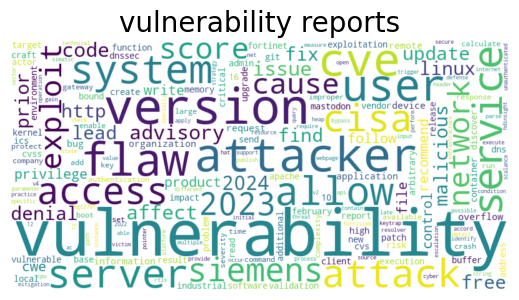

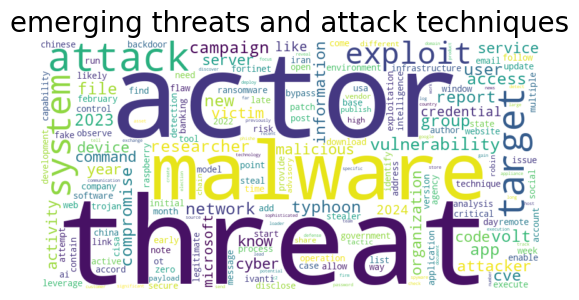

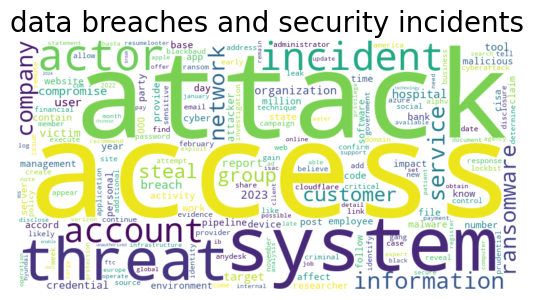

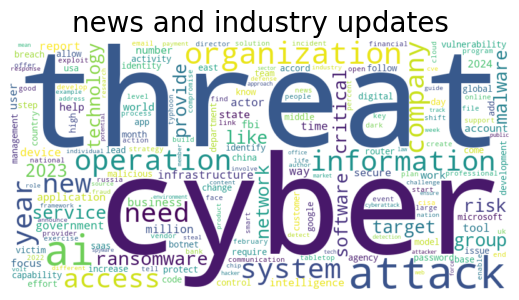

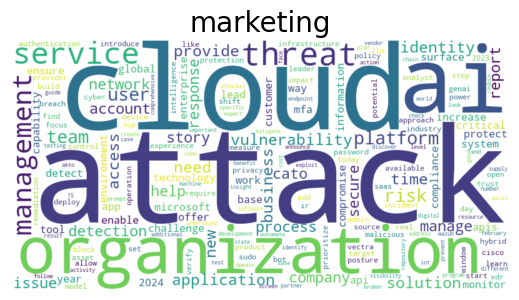

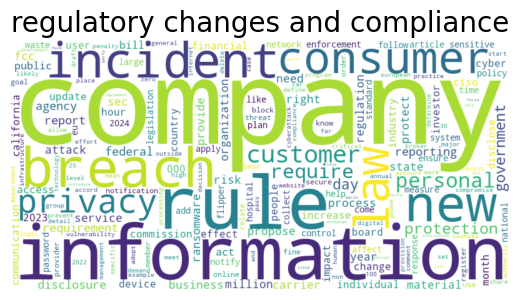

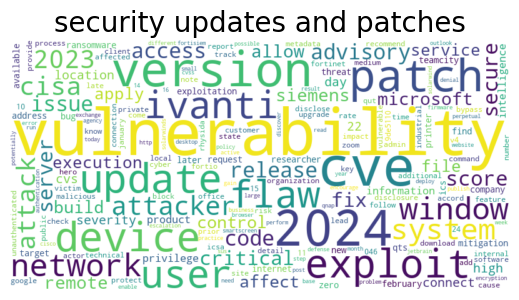

In [22]:
# Expand the list of words into a new row for each word
words_clean = words.explode('words').rename(columns={'words': 'word'})
words_clean = words_clean[words_clean['word'] != ""]  # Remove empty words

# Calculate word frequencies by category
word_frequencies_by_category = words_clean.groupby(['category', 'word']).size().reset_index(name='n')

# Iterate through each unique category to generate word clouds
for category in words_clean['category'].unique():
    # Filter data for the current category
    cat_data = word_frequencies_by_category[word_frequencies_by_category['category'] == category]

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
        dict(zip(cat_data['word'], cat_data['n'])))

    # Plotting the WordCloud                    
    plt.figure(figsize=(5, 2.5), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.title(category, fontsize=20)
    plt.show()

## Fitting Models

### Method 1: Zero Shot Classification



#### Method 1.1: Zero-Shot with BART Large

In [23]:
%%capture
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

                                        precision    recall  f1-score   support

                 vulnerability reports       0.50      0.51      0.51        47
          security updates and patches       0.44      0.84      0.57        92
emerging threats and attack techniques       0.50      0.03      0.06        33
     regulatory changes and compliance       0.41      0.26      0.32        91
  data breaches and security incidents       0.50      0.36      0.42        33
             news and industry updates       0.55      0.41      0.47        29
                             marketing       0.23      0.15      0.18        20

                              accuracy                           0.44       345
                             macro avg       0.45      0.37      0.36       345
                          weighted avg       0.45      0.44      0.40       345

Cross-Entropy Loss / Log Loss: 2.4201206392797916


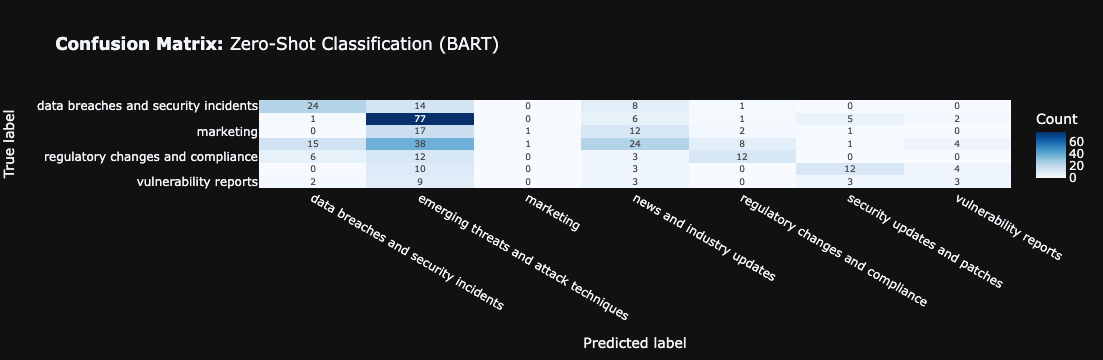

In [24]:
candidate_labels = ['vulnerability reports',
                    'security updates and patches',
                    'emerging threats and attack techniques',
                    'regulatory changes and compliance',
                    'data breaches and security incidents',
                    'news and industry updates',
                    'marketing']

# Function for BART Zero-Shot classification, slightly modified for simplicity
def bart_zero_shot(sequence):
    classified_sequence = classifier(sequence, candidate_labels)
    classified_scores = {label: classified_sequence['scores'][classified_sequence['labels'].index(label)] for label in candidate_labels}
    category = max(classified_scores, key=classified_scores.get)
    return pd.Series([category, classified_scores])

# Create new classifications or load existing if available 
if not os.path.exists('./data/bartZero.csv'):
    bdata = pd.DataFrame(data[['content', 'category']])
    bdata[['bart-zero-category', 'bart-zero-scores']] = bdata['content'].apply(bart_zero_shot)
    bdata.to_csv('./data/bartZero.csv')
else:
    bdata = pd.read_csv('./data/bartZero.csv')
    bdata['bart-zero-scores'] = bdata['bart-zero-scores'].apply(ast.literal_eval) 

    
    
# Creating a probability matrix for log loss
prob_matrix = np.array(bdata['bart-zero-scores'].apply(lambda scores_dict: [scores_dict.get(label, 0) for label in candidate_labels]).tolist())

# True labels from the 'category' column
true_labels = bdata['category'].tolist()

# Predicted labels from the 'bart-zero-category' column
predicted_labels = bdata['bart-zero-category'].tolist()

# Encode labels for log loss calculation
label_encoder = LabelEncoder()
label_encoder.fit(candidate_labels)
true_labels_encoded = label_encoder.transform(true_labels)
predicted_labels_encoded = label_encoder.transform(predicted_labels)

# Classification report using true and predicted labels
print(classification_report(true_labels, predicted_labels, target_names=candidate_labels))

# Calculate Log Loss
loss = log_loss(true_labels_encoded, prob_matrix, labels=range(len(candidate_labels)))
print(f"Cross-Entropy Loss / Log Loss: {loss}")

# Generate Confusion Matrix
cm = confusion_matrix(true_labels_encoded, predicted_labels_encoded)

# Plot Confusion Matrix
fig = px.imshow(cm, x=label_encoder.classes_, y=label_encoder.classes_, text_auto=True, aspect="auto",
                labels=dict(x="Predicted label", y="True label", color="Count"), color_continuous_scale='Blues',
                title='<b>Confusion Matrix:</b> Zero-Shot Classification (BART)')
fig.show()

#### Method 1.2 Zero-Shot with GPT-3.5

In [25]:
zodata = pd.DataFrame(data[['content', 'category']])

candidate_labels = ['vulnerability reports',
                    'security updates and patches',
                    'emerging threats and attack techniques',
                    'regulatory changes and compliance',
                    'data breaches and security incidents',
                    'news and industry updates',
                    'marketing']

sys_msg = instruction = """
analyze an article's content to determine its fit across predefined categories: 'vulnerability reports', 'security updates and patches', 'emerging threats and attack techniques', 'regulatory changes and compliance', 'data breaches and security incidents', 'news and industry updates', 'marketing'. output a json dictionary with categories as keys and the probability (as a floating point number) of the article belonging to each category as values. ensure the probabilities sum up to no more than 1, with the highest probability indicating the primary classification. always output all seven categories, even if they have a zero probability.
"""


def get_oai_zero_shot(content):
    response = client.chat.completions.create(
  seed=42,
  model="gpt-3.5-turbo-0125",
  response_format={ "type": "json_object" },
  messages=[
    {"role": "system", "content": sys_msg},
    {"role": "user", "content": content}
  ]
)
    zoai_probs = json.loads(response.choices[0].message.content)
    category = max(zoai_probs, key=zoai_probs.get)
    return pd.Series([category, json.dumps(zoai_probs)])

subset = zodata.sample(n=3, random_state=42)

# Commented to prevent accidental triggering.
#zodata[['oai-zero-category', 'oai-zero-scores']] = zodata['content'].apply(get_oai_zero_shot) 
#zodata.to_csv('./data/zeroOaiData.csv')


                                        precision    recall  f1-score   support

                 vulnerability reports       0.70      0.49      0.57        47
          security updates and patches       0.49      0.73      0.58        92
emerging threats and attack techniques       0.00      0.00      0.00        33
     regulatory changes and compliance       0.51      0.26      0.35        91
  data breaches and security incidents       0.68      0.58      0.62        33
             news and industry updates       0.11      0.07      0.08        29
                             marketing       0.23      0.90      0.36        20

                              accuracy                           0.44       345
                             macro avg       0.39      0.43      0.37       345
                          weighted avg       0.45      0.44      0.41       345

Cross-Entropy Loss / Log Loss: 13.548938293958768


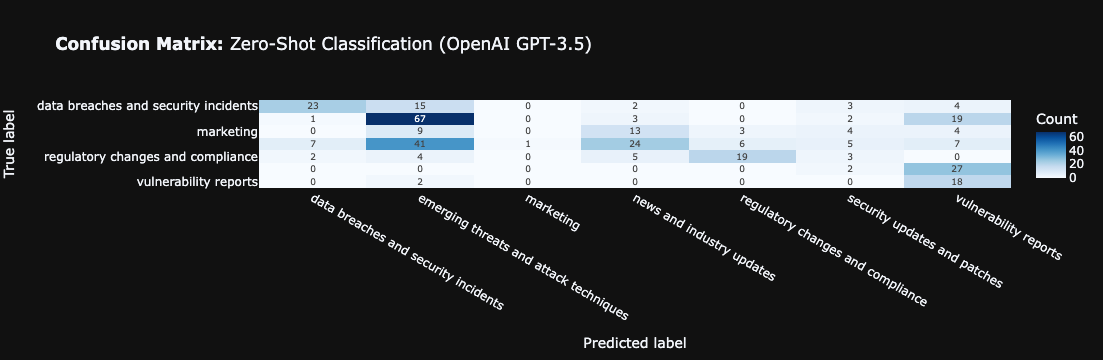

In [26]:
zodata = pd.read_csv('./data/zeroOaiData.csv')
zodata['oai-zero-scores'] = zodata['oai-zero-scores'].apply(json.loads) 

# Creating a probability matrix for log loss
prob_matrix = np.array(zodata['oai-zero-scores'].apply(lambda scores_dict: [scores_dict.get(label, 0) for label in candidate_labels]).tolist())

# True labels from the 'category' column
true_labels = zodata['category'].tolist()

# Predicted labels from the 'bart-zero-category' column
predicted_labels = zodata['oai-zero-category'].tolist()

# Encode labels for log loss calculation
label_encoder = LabelEncoder()
label_encoder.fit(candidate_labels)
true_labels_encoded = label_encoder.transform(true_labels)
predicted_labels_encoded = label_encoder.transform(predicted_labels)

# Classification report using true and predicted labels
print(classification_report(true_labels, predicted_labels, target_names=candidate_labels))

# Calculate Log Loss
loss = log_loss(true_labels_encoded, prob_matrix, labels=range(len(candidate_labels)))
print(f"Cross-Entropy Loss / Log Loss: {loss}")

# Generate Confusion Matrix
cm = confusion_matrix(true_labels_encoded, predicted_labels_encoded)

# Plot Confusion Matrix
fig = px.imshow(cm, x=label_encoder.classes_, y=label_encoder.classes_, text_auto=True, aspect="auto",
                labels=dict(x="Predicted label", y="True label", color="Count"), color_continuous_scale='Blues',
                title='<b>Confusion Matrix:</b> Zero-Shot Classification (OpenAI GPT-3.5)')
fig.show()

### Evaluation

#### Interpreting Results
For **BART Large**, the metrics reveal a nuanced view of its performance capabilities. The model has a precision of 45% and a recall of 44%, indicating its balanced yet distinct capabilities in identifying relevant articles while also capturing a significant portion of actual relevant instances. The F1-score, a measure of the test's accuracy, stands at 40%, suggesting a moderate balance between precision and recall. Interestingly, this model shows a particular strength in the "security updates and patches" category, where it demonstrates a higher recall. This indicates its effectiveness in identifying articles within this specific area, which is crucial for tasks focused on security-related content. The overall accuracy of the model is 44%, meaning it correctly classifies articles 44% of the time, which is below half but still indicative of its capability to make correct predictions in a variety of contexts. The Cross-Entropy Loss, at 2.42, points towards the model's predictions being relatively close to actual outcomes, reflecting a reasonable level of confidence in its classifications.


For **OpenAI GPT-3.5**, this model's performance metrics slightly vary. It has a precision of 45%, matching BART Large in its ability to accurately label articles as belonging to the correct category. The F1-score is calculated at 41%, showing a slight variation in how well it maintains a balance between precision and recall compared to BART Large. The model's standout feature is its performance in the "marketing" category, where it achieves a high recall, indicating its strength in identifying most articles of this type, despite a tendency to overclassify in this area. Like BART Large, the accuracy of OpenAI GPT-3.5 stands at 44%, underlining a similar level of effectiveness in correctly classifying articles across various categories. However, a significant divergence is seen in the Cross-Entropy Loss, which is notably higher at 13.55. This suggests a considerable gap between the model's predictions and the actual classifications, pointing to less confidence in its predictions across the board.

#### Comparison
When comparing the two models directly, the similar precision and accuracy rates indicate that both models are equally effective in accurately labeling articles when they predict a category. The slightly higher F1-score of GPT-3.5 suggests a minor advantage in maintaining a balance between precision and recall, implying that it might be slightly better at general classification tasks when considering all categories equally.

However, the key differentiator between the two models is their Cross-Entropy Loss. BART Large's Cross-Entropy Loss is significantly lower (2.42 compared to 13.55), indicating that its predictions are more aligned with the actual classifications and it is generally more confident in its classifications. This metric suggests that BART Large is a more reliable choice for applications where the confidence of prediction is crucial.

BART Large is the better model for tasks requiring high reliability and confidence in outcomes. Its significantly lower Cross-Entropy Loss indicates a higher confidence in its predictions, making it a more reliable and accurate choice for classifying articles. This clear advantage in prediction confidence, coupled with its balanced precision and recall, establishes BART Large as the superior option for applications requiring dependable and precise classification.

#### Next Steps
Following our evaluation of the zero-shot classification capabilities of BART Large and OpenAI GPT-3.5 models, we've identified certain limitations inherent in zero-shot learning approaches. Zero-shot classification, while powerful for its ability to handle categories not seen during training, often struggles with the precise contextual nuances of text data and may not always align with specific domain requirements due to its generalized training. These limitations highlight the potential for decreased accuracy and confidence in predictions, especially in specialized or narrowly defined categories.

As an alternative, we plan to explore traditional machine learning techniques, specifically applying a Bag of Words model enhanced with Term Frequency-Inverse Document Frequency (TF-IDF) weighting. This approach is aimed at converting text data into a numerical format that reflects not just the presence of words but their relative importance, providing a richer set of features for classification tasks.

### Method 2: Bag of Words using TF-IDF
#### Introduction
To address the weaknesses observed in zero-shot classification, we will compare two well-established classifiers: Multinomial Naive Bayes (MultinomialNB) and Multi-Layer Perceptron (MLPClassifier). MultinomialNB is renowned for its effectiveness in text classification due to its simplicity and the probabilistic insights it offers, making it particularly adept at handling the frequency-based features generated by the Bag of Words model. Its strength lies in its ability to make strong predictions based on the statistical properties of the words in documents, offering a solid baseline for performance evaluation.

In contrast, MLPClassifier represents a more sophisticated approach, harnessing the power of neural networks to capture complex, nonlinear relationships in the data. This method has the potential to uncover deeper patterns and interactions between features, which might be missed by simpler models. The flexibility and adjustable complexity of MLPClassifier make it a promising candidate for achieving higher accuracy in scenarios where the relationships between words and their predictive power are not straightforward.

Our objective in this next phase is twofold: to leverage the strengths of traditional machine learning methods in overcoming the specific limitations of zero-shot classification and to empirically determine which approach—MultinomialNB or MLPClassifier—offers the best trade-off between accuracy, computational efficiency, and interpretability for our text classification needs. By doing so, we aim to identify a robust and reliable method that can address the nuanced requirements of our classification task, capitalizing on the detailed feature representation provided by the TF-IDF weighted Bag of Words model.

#### Methodology
In this model pipeline, a series of steps are executed to pre-process the data, address class imbalance, and finally classify the data using a neural network.

1.  **Vectorization** *('vect', CountVectorizer())*: This first step uses a CountVectorizer to convert data['processed_content'] into a matrix of token counts by breacking the test into words (or tokens) and counting the occurence of each token in the dataset. The CountVectorizer focuses on the frequency of words used across documents.
2.  **Term Frequency Normalization** *('tfidf', TfidfTransformer(use_idf=False))*: After the initial vectorization step, the pipeline employs the TfidfTransformer without inverse document frequency (use_idf=False). This adjustment signifies that the transformer will not calculate the IDF values for each word across the documents. Without IDF, this step focuses on scaling the frequency of words withint each document to a standard range, ensuring that the length of the document does not disprpoportionately influence how it's understood or represented by the model.
3.  **Class Imbalance Handling** *('smote', SMOTE(random_state=42))*: The [SMOTE (Synthetic Minority Over-sampling Technique)](https://www.wikiwand.com/en/Oversampling_and_undersampling_in_data_analysis#SMOTE) step addresses class imbalance in the training data. Class imbalance can significantly affect the performance of machine learning models, leading to a bias towards the majority class; and as previously identified, this dataset suffers greatly from class imbalance. SMOTE generates synthetic samples from the minority class to create a balanced dataset, improving the classifier's ability to learn from an evenly distributed dataset.
4.  **Classification** *('clf', MLPClassifier(random_state=42))*: The final step in the pipeline employs an MLPClassifier, a type of neural network known as a Multi-Layer Perceptron. This classifier uses backpropagation for training, adjusting weights to minimize the error between predicted and actual classifications. The MLPClassifier is capable of capturing complex relationships in the data through its hidden layers, making it a powerful tool for classification tasks.

A fair bit of hyperparameter tuning took place, including the use of GridSearchCV to perform an exhaustive search for the best hyperparameter values given a range of values for each. The tables below show a range of models attempted along with hyperparameter tunings that gave the best results for each classifier.

These are the classifiers and hyperparameter settings that yielded the best accuracy and weighted precision for each classifier, ultimately MLPClassifier() and MultinomialNB(alpha=0.1) proved the best two.

MLPClassifier()
ComplementNB(alpha=0.1)
RandomForestClassifier(criterion="log_loss", random_state=42)
MultinomialNB(alpha=0.1)
GradientBoostingClassifier(max_depth=4, random_state=42) 


MultinomialNB

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.80      0.67      0.73        12
emerging threats and attack techniques       0.71      0.87      0.78        23
                             marketing       0.60      0.33      0.43         9
             news and industry updates       0.56      0.78      0.65        23
     regulatory changes and compliance       1.00      0.50      0.67         8
          security updates and patches       0.75      0.43      0.55         7
                 vulnerability reports       0.75      0.60      0.67         5

                              accuracy                           0.68        87
                             macro avg       0.74      0.60      0.64        87
                          weighted avg       0.71      0.68      0.67        87

Cross-Entropy Loss / Log Loss: 1.6199747174207724


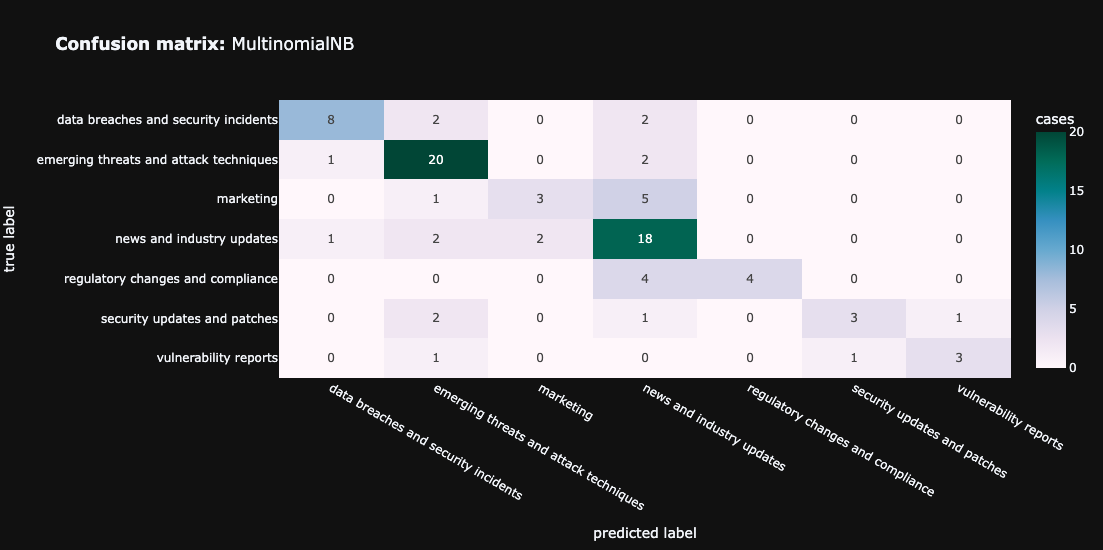

MLPClassifier

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.83      0.83      0.83        12
emerging threats and attack techniques       0.79      0.83      0.81        23
                             marketing       0.50      0.56      0.53         9
             news and industry updates       0.65      0.65      0.65        23
     regulatory changes and compliance       0.83      0.62      0.71         8
          security updates and patches       0.75      0.86      0.80         7
                 vulnerability reports       0.75      0.60      0.67         5

                              accuracy                           0.72        87
                             macro avg       0.73      0.71      0.71        87
                          weighted avg       0.73      0.72      0.72        87

Cross-Entropy Loss / Log Loss: 0.7743061198073148


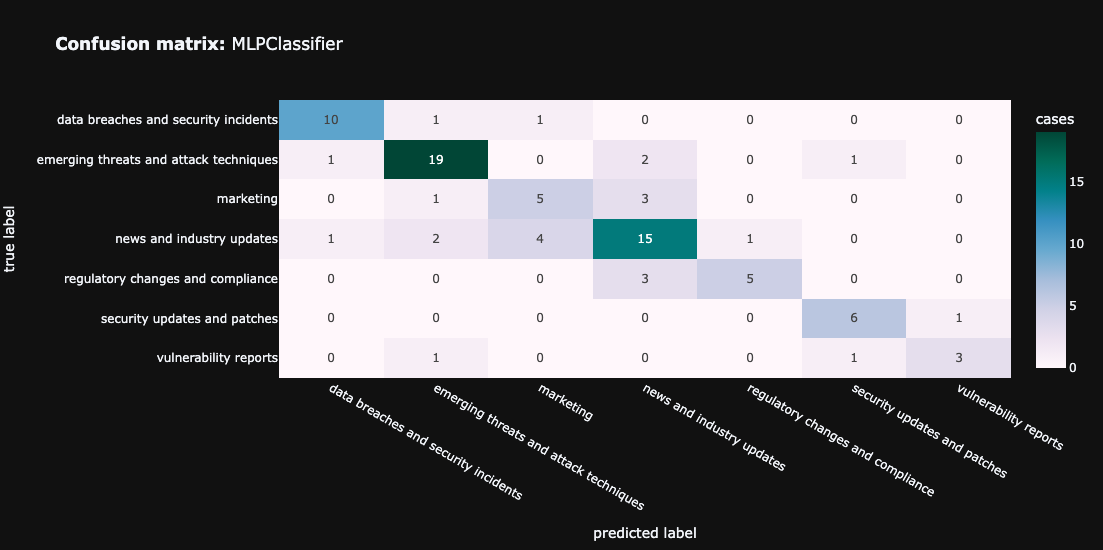

In [30]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    data['processed_content'],
    data['category'],
    test_size=.25,
    random_state=42,
    stratify=data['category']
)


# Build a function for fitting the model on different classifiers.
def bow_benchmark(clf):
    display(Markdown(f"{clf.__class__.__name__}"))

    # Model Pipeline
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('smote', SMOTE(random_state=42)),
        ('clf', clf),
    ])
    # Train the classifier
    text_clf.fit(X_train, y_train)

    # Evaluate the classifier
    predicted = text_clf.predict(X_test)
    predicted_probs = text_clf.predict_proba(X_test)
    predicted_probs = np.divide(predicted_probs, np.sum(predicted_probs, axis=1)[:, np.newaxis])
    print(classification_report(y_test, predicted))
    loss = log_loss(y_test, predicted_probs)
    print(f"Cross-Entropy Loss / Log Loss: {loss}")

    cm = confusion_matrix(y_test, predicted)

    fig = px.imshow(
        cm, x=clf.classes_,
        y=clf.classes_, text_auto='d',
        aspect="auto",
        labels=dict(
            x="predicted label", y="true label",
            color="cases"),
        color_continuous_scale='pubugn',
        title=f'<b>Confusion matrix:</b> {clf.__class__.__name__}', height=550)

    fig.show()


for clf in {
    (MLPClassifier(random_state=42)),
    (MultinomialNB(alpha=0.001))
}:
    bow_benchmark(clf)

### Evaluation

#### Interpreting Results
The **MLPClassifier** model, when combined with a Bag of Words and TF-IDF approach, demonstrates a solid performance across various categories. It achieves a precision of 73%, a recall of 71%, and a weighted average F1-score of 72%. These metrics suggest a strong balance in the model's ability to accurately identify and classify articles into their respective categories. Notably, the model excels in classifying "data breaches and security incidents" and "emerging threats and attack techniques" with high precision and recall, indicating its effectiveness in recognizing more critical security-related content. The overall accuracy stands at 72%, showing that it can correctly classify articles more than two-thirds of the time. The Cross-Entropy Loss for this model is relatively low at 0.774, suggesting that its predictions are fairly confident and closely aligned with the actual outcomes.
 
The **MultinomialNB** model exhibits a slightly different performance profile. With a precision of 74%, a recall of 60%, and a weighted average F1-score of 67%, it shows a decent ability to classify articles, though with a bit more variability in effectiveness across categories compared to the MLPClassifier. It performs exceptionally well in "emerging threats and attack techniques" and "news and industry updates," highlighting its capacity to handle content with varied complexity. The accuracy of this model is 68%, indicating a slightly lower but still competent ability to classify articles correctly compared to MLPClassifier. However, the Cross-Entropy Loss is higher at 1.619, indicating a less confident prediction alignment with the actual categories.
 
#### Comparison
Comparing the MLPClassifier and MultinomialNB models reveals that the MLPClassifier slightly outperforms MultinomialNB in terms of overall accuracy, balance in precision and recall, and especially in confidence of predictions as indicated by the lower Cross-Entropy Loss. This suggests that for tasks requiring high reliability and confidence, the MLPClassifier would be the more suitable choice among the two when using Bag of Words and TF-IDF methods.

#### Next Steps
While the Bag of Words with TF-IDF weighting has proven effective, especially with the MLPClassifier model, it has its limitations. This method can overlook the semantic relationships between words, as it focuses on word frequency rather than context, potentially leading to a loss of meaning in more complex texts. To address these limitations, we plan to explore the use of embeddings, specifically with SBERT and OpenAI models. Embeddings can capture the contextual nuances of language by representing words and phrases in dense vector spaces, potentially offering a deeper understanding of the text.

By employing embeddings, we aim to overcome the weaknesses of Bag of Words + TF-IDF, such as its inability to handle polysemy (words with multiple meanings) and to capture deeper semantic relationships. We hope that SBERT and OpenAI's embedding approaches will provide more nuanced and context-aware representations, leading to improved classification accuracy and reliability across a wider range of text complexities. This step represents a move towards leveraging state-of-the-art language understanding capabilities to enhance our text classification efforts further.



### Method 3: Embeddings


#### Method 3.1: Sentence Embeddings using SBERT
In this refined model pipeline, we address some of the limitations inherent in the bag of words approach by leveraging the advanced capabilities of SBERT for sentence embeddings. Here's how we've structured this approach.

**Sentence Embeddings ('sbert_model', SentenceTransformer('multi-qa-mpnet-base-dot-v1'))**: Begin by transforming our data into rich, dense embeddings using SBERT. Unlike the CountVectorizer, which treats each word in isolation, SBERT understands the context around each word, capturing the subtleties of language more effectively.

We iterate over a selection of classifiers, comparing their performance to identify the most effective approach for our classification task. In this pipeline, we focus on MLPClassifier and Logistic Regression, leveraging the dense representations from SBERT to train these models. Similar to the first approach, we tested numerous classifiers and reported on the two most effective:

RandomForestClassifier(criterion='log_loss', max_depth=10),
MLPClassifier(random_state=42),
LogisticRegression(),
MLPClassifier(),
GradientBoostingClassifier(max_depth=4, random_state=42)

This method aims to transcend the limitations of traditional bag of words models by incorporating the advanced NLP capabilities of SBERT, setting the stage for more accurate and contextually aware text classification.

*Thanks to [Thomas Wong](https://towardsdatascience.com/easily-get-high-quality-embeddings-with-sentencetransformers-c61c0169864b) and [Mariya Mansurova](https://towardsdatascience.com/text-embeddings-comprehensive-guide-afd97fce8fb5) for their guidance on working with SBERT embeddings*

In [28]:
%%capture
sbert_model = SentenceTransformer('multi-qa-mpnet-base-dot-v1', device=device)

In [49]:
def get_embeddings(sentences):
    """
    Get embeddings for a list of sentences.
    The final embeddings is the mean of all sentence embeddings.
    
    :param sentences: list of str. Input sentences.
    :return: np.array. The mean embeddings of the sentences.
    """
    # Ensure that the input is a list of sentences
    if not isinstance(sentences, list):
        raise ValueError("Input must be a list of sentences")

    # Encode the sentences using the model and calculate the mean embeddings
    return np.mean(sbert_model.encode(sentences), axis=0)


sdata = data[['sentences', 'category']]
sdata['embeddings'] = sdata['sentences'].apply(get_embeddings)


MLPClassifier

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.69      0.75      0.72        12
emerging threats and attack techniques       0.65      0.87      0.74        23
                             marketing       0.50      0.33      0.40         9
             news and industry updates       0.75      0.65      0.70        23
     regulatory changes and compliance       1.00      0.88      0.93         8
          security updates and patches       0.67      0.29      0.40         7
                 vulnerability reports       0.43      0.60      0.50         5

                              accuracy                           0.68        87
                             macro avg       0.67      0.62      0.63        87
                          weighted avg       0.69      0.68      0.67        87

Cross-Entropy Loss / Log Loss: 1.1309231766874692


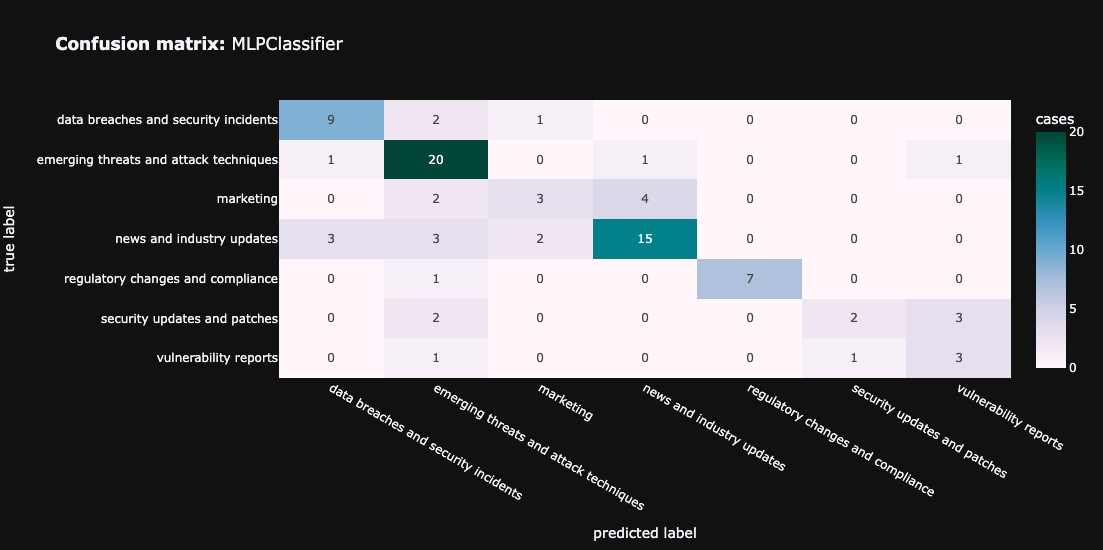

LogisticRegression

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.71      0.83      0.77        12
emerging threats and attack techniques       0.62      0.91      0.74        23
                             marketing       0.67      0.44      0.53         9
             news and industry updates       0.74      0.61      0.67        23
     regulatory changes and compliance       1.00      0.75      0.86         8
          security updates and patches       1.00      0.14      0.25         7
                 vulnerability reports       0.43      0.60      0.50         5

                              accuracy                           0.68        87
                             macro avg       0.74      0.61      0.62        87
                          weighted avg       0.72      0.68      0.66        87

Cross-Entropy Loss / Log Loss: 0.8516745793228473


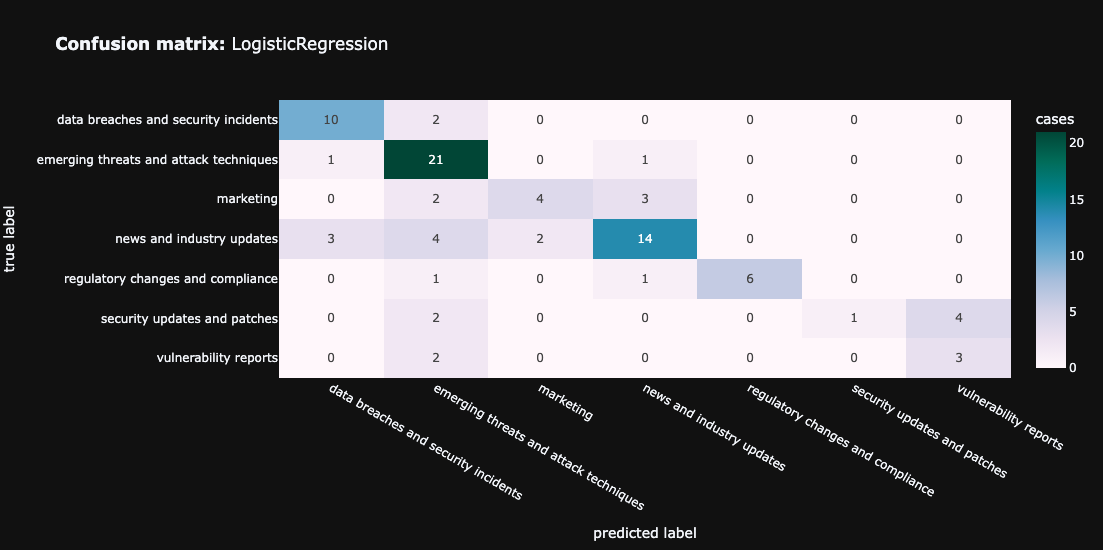

In [50]:
X = np.stack(sdata['embeddings'].values)
y = sdata['category'].values

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.25,
    random_state=42,
    stratify=y
)


def embed_benchmark(clf):
    display(Markdown(clf.__class__.__name__))
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    predicted_probs = clf.predict_proba(X_test)
    predicted_probs = np.divide(predicted_probs, np.sum(predicted_probs, axis=1)[:, np.newaxis])
    print(classification_report(y_test, predicted))
    loss = log_loss(y_test, predicted_probs)
    print(f"Cross-Entropy Loss / Log Loss: {loss}")

    cm = confusion_matrix(y_test, predicted)

    fig = px.imshow(
        cm, x=clf.classes_,
        y=clf.classes_, text_auto='d',
        aspect="auto",
        labels=dict(
            x="predicted label", y="true label",
            color="cases"),
        color_continuous_scale='pubugn',
        title=f'<b>Confusion matrix:</b> {clf.__class__.__name__}', height=550)

    fig.show()


classifiers = {
    MLPClassifier(random_state=42),
    LogisticRegression(random_state=42)
}

for clf in classifiers:
    embed_benchmark(clf)

#### Method 3.2: Document Embeddings with OpenAI

Here we perform the same steps as with SBERT classification, only this time using embeddings from OpenAI's 'text-embedding-3-large' model which provides a distinct advantage in terms of leveraging the vast, diverse dataset OpenAI has access to, incorporating broader linguistic patterns and nuances. Unlike SBERT, which optimizes BERT for generating sentence-level embeddings with a focus on enhancing performance and speed for specific NLP tasks, OpenAI's model benefits from a more generalized training approach. This allows it to capture a wider array of semantic relationships and contextual cues across different types of text, potentially offering more nuanced and comprehensive embeddings for complex texts such as cybersecurity articles. The same classifiers were tested from the SBERT method, although this method benefitted greatly from hyperparameter tuning whereas the default settings yielded the best results on SBERT. 

None of our articles exceed 8191 tokens, so we can proceed with our full dataset.

In [44]:
# Subset the original content and create OpenAI embeddings. Save the embedded data to disk to avoid costs associated with re-processing.
embedding_model = "text-embedding-3-large"

def get_oai_embeddings(text):
    response = client.embeddings.create(
        model=embedding_model,
        input=[text]
    )
    return response.data[0].embedding  # Change this

oaidata = data[['content', 'category']]
# oaidata['embeddings'] = oaidata['content'].apply(get_oai_embeddings)  # This costs $, use only as needed
# oaidata.to_csv('./data/oaiData.csv')


In [45]:
embeddedData = pd.read_csv('./data/oaiData.csv')
embeddedData['embeddings'] = embeddedData['embeddings'].apply(eval).apply(np.array)

LogisticRegression

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.77      0.83      0.80        12
emerging threats and attack techniques       0.77      0.87      0.82        23
                             marketing       0.70      0.78      0.74         9
             news and industry updates       0.79      0.65      0.71        23
     regulatory changes and compliance       0.83      0.62      0.71         8
          security updates and patches       0.50      0.43      0.46         7
                 vulnerability reports       0.57      0.80      0.67         5

                              accuracy                           0.74        87
                             macro avg       0.70      0.71      0.70        87
                          weighted avg       0.74      0.74      0.73        87

Cross-Entropy Loss / Log Loss: 1.2518426401677203


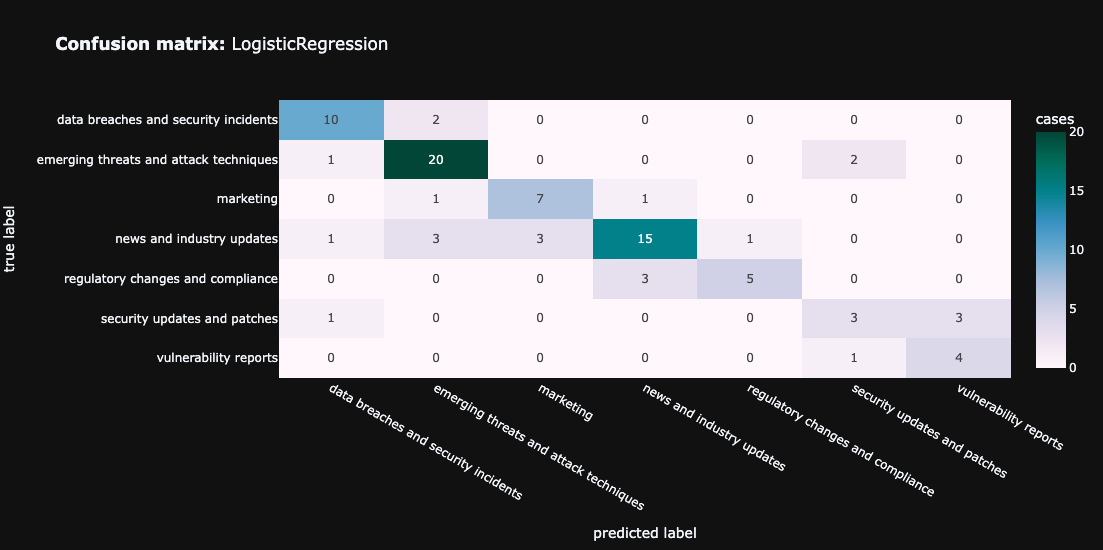

MLPClassifier

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.79      0.92      0.85        12
emerging threats and attack techniques       0.75      0.91      0.82        23
                             marketing       0.71      0.56      0.62         9
             news and industry updates       0.76      0.70      0.73        23
     regulatory changes and compliance       1.00      0.62      0.77         8
          security updates and patches       0.60      0.43      0.50         7
                 vulnerability reports       0.57      0.80      0.67         5

                              accuracy                           0.75        87
                             macro avg       0.74      0.70      0.71        87
                          weighted avg       0.76      0.75      0.74        87

Cross-Entropy Loss / Log Loss: 0.7255349050221034


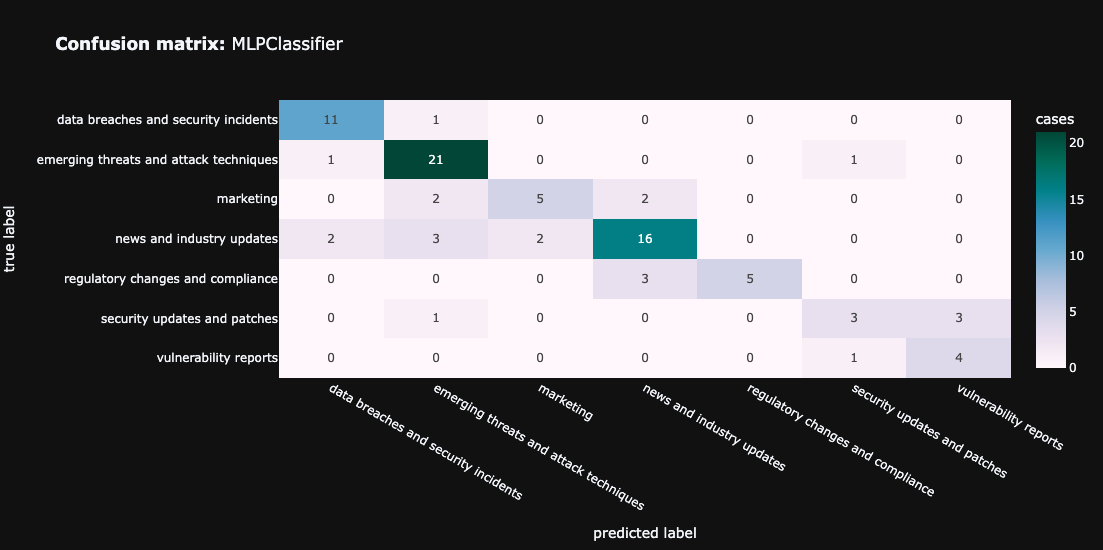

In [46]:
X = np.stack(embeddedData['embeddings'].values)
y = embeddedData['category'].values

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.25,
    random_state=42,
    stratify=y
)

classifiers = {
    MLPClassifier(random_state=42),
    LogisticRegression(class_weight='balanced', solver='newton-cholesky', n_jobs=-1, random_state=42),

}

for clf in classifiers:
    embed_benchmark(clf)

### Evaluation

#### Interpreting Results

##### SBERT
Utilizing SBERT embeddings, the **MLPClassifier** achieves a precision of 69%, recall of 68%, and a weighted average F1-score of 67%. This performance indicates a solid capability in categorizing articles, with particular strengths in "regulatory changes and compliance" where it shows remarkable precision and recall. However, it struggles with "security updates and patches," reflecting a potential area for improvement. The overall accuracy stands at 68%, and the Cross-Entropy Loss is 1.1309, suggesting a fair level of prediction confidence.

The **Logistic Regression** model, when applied with SBERT embeddings, shows a precision of 72%, recall of 68%, and a weighted average F1-score of 66%. This model excels in "emerging threats and attack techniques," with high recall, but shows a notable deficiency in accurately predicting "security updates and patches." The accuracy here is also 68%, with a better Cross-Entropy Loss at 0.8517, indicating a higher confidence in its predictions compared to the MLPClassifier.
##### OpenAI
The **MLPClassifier**, paired with OpenAI embeddings, showcases a precision of 76%, recall of 75%, and a weighted average F1-score of 74%, making it the best performer among the four setups. It shines particularly in "data breaches and security incidents" and "emerging threats and attack techniques." With the highest accuracy of 75% and the lowest Cross-Entropy Loss of 0.7255, it indicates the most reliable and confident predictions across the board.

With OpenAI embeddings, the **Logistic Regression** model demonstrates a precision of 74%, recall of 74%, and a weighted average F1-score of 73%. It performs notably well across "emerging threats and attack techniques" and "marketing," but shows some weaknesses in "security updates and patches." The model achieves an accuracy of 74% and has a Cross-Entropy Loss of 1.2518, which reflects moderately confident predictions.

The **MLPClassifier** emerges as the superior model within the OpenAI embeddings method, due to its highest accuracy and lowest Cross-Entropy Loss, indicating both effective classification and high confidence in predictions. Within the SBERT embeddings method, **Logistic Regression** outperforms the MLPClassifier, primarily due to its lower Cross-Entropy Loss, reflecting higher prediction confidence.

#### Comparison
In comparing the performance of the MLPClassifier with OpenAI embeddings against the Logistic Regression with SBERT embeddings, we observe distinct advantages in favor of the MLPClassifier with OpenAI. Specifically, this model achieves a precision of 76%, compared to the Logistic Regression's 72% with SBERT, illustrating its superior accuracy in classifying articles correctly. Furthermore, its recall rate of 75% surpasses the Logistic Regression model's 68%, indicating that it is more effective in identifying relevant articles across all categories. The F1-score, which balances precision and recall, stands at 74% for the MLPClassifier with OpenAI, versus 66% for the Logistic Regression with SBERT, further underlining the MLPClassifier's superior capability to maintain a harmonious balance between precision and recall. Additionally, the Cross-Entropy Loss of 0.7255 for the MLPClassifier with OpenAI is significantly lower than the 0.8517 observed for the Logistic Regression with SBERT, demonstrating a higher confidence in its predictions and a closer alignment with the actual outcomes. These numerical differences highlight why the MLPClassifier with OpenAI embeddings is considered the better model, offering both higher accuracy and confidence in its text classification tasks.

#### Next Steps
While embeddings have shown promising improvements over the Bag of Words + TF-IDF approach, especially in capturing semantic relationships, there are other ways to enhance our text classification efforts further. Advanced techniques such as fine-tuning pre-trained language models, exploring more complex neural network architectures, or incorporating external knowledge bases could potentially offer gains in accuracy and robustness. However, a critical next step involves addressing the dataset's limitations, particularly the need for more data and improving class imbalances. Expanding the dataset and ensuring a more balanced representation of categories will be crucial in training more effective models and achieving better generalization in future classification tasks.

## Conclusion
In addressing the challenge of efficiently categorizing a vast daily influx of information security news articles, a data-driven approach was adopted to develop an automated categorization model. The initial goal was to sift through approximately 100 to 200 articles per day, a task that previously required significant manual effort. This report outlines the evolution of the model development process, from initial experiments with zero-shot classification to the final implementation using a Multi-Layer Perceptron (MLP) classifier with OpenAI Embeddings, highlighting the decision-making process backed by quantitative evaluations.

### Initial Approach: Zero-Shot Classification
The project began with an exploration of zero-shot classification techniques, utilizing the bart-large-mnli model. This approach offered the advantage of not requiring labeled training data, potentially saving considerable time in the data preparation phase. However, the performance metrics indicated limitations in accuracy and precision. The best zero-shot models achieved an accuracy of around 44%, with a Cross-Entropy Loss ranging from 2.42 to 13.55, reflecting a considerable gap between the models' predictions and actual classifications. The inability of zero-shot models to capture the nuanced context and specificity required for cybersecurity content led to the exploration of alternative methods.

### Transition to Bag of Words and TF-IDF
To improve model performance, a shift towards a traditional Bag of Words model with TF-IDF weighting was made. This method improved feature representation by emphasizing the importance of specific terms within and across documents. The introduction of machine learning classifiers, specifically the MLPClassifier and Multinomial Naive Bayes, marked a significant improvement. The MLPClassifier, when applied with TF-IDF, demonstrated a better balance between precision (73%) and recall (71%), with a weighted average F1-score of 72% and a notably lower Cross-Entropy Loss of 0.774. This improvement justified the transition from zero-shot models to more traditional text representation and classification techniques.

### Advancement with Embeddings
Further advancements were made by integrating sentence and document embeddings, utilizing SBERT and OpenAI's Embeddings. This approach allowed for a richer representation of text, capturing semantic relationships more effectively than the Bag of Words model. The MLPClassifier, when combined with OpenAI Embeddings, showcased the most promising results: a precision of 76%, recall of 75%, and a weighted average F1-score of 74%, with the lowest Cross-Entropy Loss observed at 0.7255. These metrics highlighted the embeddings' ability to provide a nuanced understanding of the content, significantly enhancing classification accuracy and model confidence.

### Conclusion and Future Directions
The development process, from zero-shot classification to leveraging state-of-the-art embeddings, underscores the importance of iterative model refinement and the adoption of advanced NLP techniques in tackling complex categorization tasks. The MLPClassifier with OpenAI Embeddings emerged as the most effective solution, offering a high degree of accuracy and efficiency in categorizing information security news articles. This journey illustrates the potential of machine learning and AI in enhancing cybersecurity operations, enabling professionals to quickly identify and act on relevant threats and trends within the vast landscape of information security news.

Future work will focus on further refining the model, exploring the integration of additional contextual information, and expanding the dataset to cover a broader range of cybersecurity topics. Continuous model evaluation and adaptation will be crucial in maintaining the relevancy and accuracy of the categorization process, ensuring it remains effective in the dynamically evolving field of cybersecurity.